<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/low_traded_incrased_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기간 입력

거래대금 하위 10%~50%

등락률 상위 50%~10%

클라스로 만들어서 백테스팅 가능하게 ㄱ

In [1]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 KB 4.7 MB/s eta 0:00:00


In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


250일 등락률, 거래대금 90-99: 범인매매

60일 등락률 50-100, 거래대금 10-50 : 조용히 오르는 애들 (내꺼)



In [3]:
period = 250

increased_low = 0.9
increased_high = 0.99

traded_low = 0.9
traded_high = 0.99

In [4]:
import pandas as pd
import requests
import datetime
import exchange_calendars as ecals # 개장일만

In [5]:
XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [6]:
today = datetime.date.today().strftime('%Y%m%d')

In [7]:
start = (datetime.date.today() - datetime.timedelta(days=period)).strftime('%Y%m%d')

if XKRX.is_session(today) == False:
  today = XKRX.previous_open(today).strftime('%Y%m%d')
if XKRX.is_session(start) == False:
  start = XKRX.next_open(start).strftime('%Y%m%d')

In [8]:
from io import StringIO

def get_stocks(market='STK'):
  data = {
    'mktId': market,
    'strtDd': start,
    'endDd': today,
    'money': '1',
    'adjStkPrc': '2',
    'adjStkPrc_check': 'Y',
    'share': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/standard/MDCSTAT01602'
  }
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  gen_key = requests.post(gen_url, data=data)

  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  r = requests.post(down_url, data={'code':gen_key.text})
  r.encoding = 'EUC-KR'

  return pd.read_csv(StringIO(r.text))

In [9]:
df = pd.concat([get_stocks(), get_stocks('KSQ')]).reset_index(drop=True)

In [10]:
df

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금
0,095570,AJ네트웍스,6540,5190,-1350,-20.64,31706769,201791794251
1,006840,AK홀딩스,16150,16240,90,0.56,2569598,40054463550
2,027410,BGF,4150,4370,220,5.30,67562110,275194299450
3,282330,BGF리테일,189500,179900,-9600,-5.07,7479458,1355809063384
4,138930,BNK금융지주,6820,6470,-350,-5.13,209464484,1417418037391
...,...,...,...,...,...,...,...,...
2469,024060,흥구석유,6270,5620,-650,-10.37,79468043,534322257730
2470,010240,흥국,6790,6220,-570,-8.39,10139885,63568476240
2471,189980,흥국에프엔비,2885,2755,-130,-4.51,64723729,189225687480
2472,037440,희림,9280,9260,-20,-0.22,422279776,4389971482650


In [11]:
traded_df = df[(df['거래대금'] < df['거래대금'].quantile(traded_high)) & (df['거래대금'] > df['거래대금'].quantile(traded_low))]

In [12]:
increased_df = df[(df['등락률'] > df['등락률'].quantile(increased_low)) & (df['등락률'] < df['등락률'].quantile(increased_high))]

In [13]:
import numpy as np

selected = pd.Series(np.intersect1d(traded_df['종목명'].values, increased_df['종목명'].values))

In [14]:
result_df = df[df['종목명'].isin(selected)].sort_values('등락률', ascending=False).head(20)

In [15]:
import FinanceDataReader as fdr

price_dic = {}
for i in result_df['종목코드']:
  price_dic[i] = fdr.DataReader(str(i),start,today)

In [16]:
def get_sharpe(df):
  change = df['Change']+1
  return change.mean()/change.std()

def get_sortino(df):
  change = df['Change']+1
  return change.mean()/(change[change<1]).std()

In [17]:
result_df['샤프'] = [get_sharpe(price_dic[x]) for x in price_dic]
result_df['소티노'] = [get_sortino(price_dic[x]) for x in price_dic]

In [18]:
result_df.sort_values('샤프', ascending=False)

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금,샤프,소티노
720,005070,코스모신소재,47700,94500,46800,98.11,116009863,7609730446550,30.906791,61.506078
1099,095660,네오위즈,23700,42650,18950,79.96,80928304,2995546254900,30.586881,53.338839
1079,121600,나노신소재,71200,141800,70600,99.16,50523074,5115938475000,30.382740,52.854182
1845,048260,오스템임플란트,97500,187100,89600,91.90,36017504,4960641110014,29.989658,62.450783
1311,086900,메디톡스,109194,203500,94306,86.37,11684843,1969759509100,28.840801,60.607092
1273,090360,로보스타,18000,33000,15000,83.33,76669586,2272257434600,27.101274,55.621465
436,006110,삼아알미늄,16900,40800,23900,141.42,65760803,2303117035100,25.535601,48.664791
1085,190510,나무가,9130,16440,7310,80.07,133378783,2085067289410,24.642150,44.824528
1760,383310,에코프로에이치엔,38200,73500,35300,92.41,37891974,2311082291750,24.221967,46.082025
1151,290670,대보마그네틱,41700,73500,31800,76.26,36839628,2494285838550,24.027140,51.558035


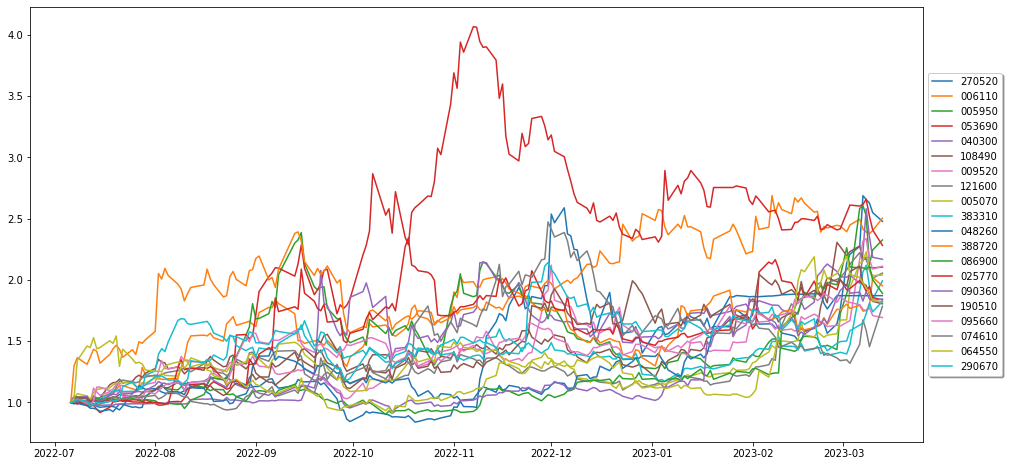

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

for i in price_dic:
  ax.plot(price_dic[i]['Close']/price_dic[i]['Close'][0], label=i)
ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

plt.show()